In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from dPCA import dPCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from collections import defaultdict
#import pca_tools
seed=31

In [53]:
def plot_components(Z,comp_in_z,time,samples,variances,area,comp_plot=3,save_fig=False,basepath=None,n_trials=None):
    n_plots,i_plot=0,0#
    for i in range(len(comp_in_z)):
        i_comp = comp_in_z[i]
        if i_plot!=0 and i_plot < comp_plot:
            ax=ax_all[i_plot]
            i_plot+=1
        else:    
            f,ax_all=plt.subplots(3,1,figsize=(10,10),sharex=True)
            ax=ax_all[0]
            i_plot =1
        for i_m in range(2):
            lstyle = '-' if i_m == 0 else '--'
            for s in samples.keys():
                ax.plot(time,Z[i_comp][i_plot-1][samples[s]][i_m],color=task_constants.PALETTE_B1[s],linestyle=lstyle)
            # max_v = np.max(Z[i_comp][i_plot-1][samples[s]])
            # min_v = np.min(Z[i_comp][i_plot-1][samples[s]])
            ax.axvline(0,color='k',linestyle='--')
            ax.axvline(450,color='k',linestyle='--')
            ax.axvline(850,color='k',linestyle='--')
            ax.text(0.5,1.05,'C%d - Exp. var: %.2f'%(i_plot,variances['component_var'][i_comp][i_plot-1]),horizontalalignment='right',verticalalignment='bottom',transform=ax.transAxes)
            ax.set_title(' ',fontsize=40)
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
        if i_plot == 1:
            ax.text(-200, ax.get_ylim()[1], 'fixation')
            ax.text(150, ax.get_ylim()[1], 'sample on')
            ax.text(600, ax.get_ylim()[1], 'delay')
            ax.text(1000, ax.get_ylim()[1], 'test on')
        if i_plot == 3:
            ax.set(xlabel='time (ms)', ylabel='Firing rate (Hz)')
        f.suptitle('%s - components: %s'%(area.upper(),i_comp))
        f.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
        if save_fig:
            path=basepath + '/fr_dpca_'+ area +'_trials_' + str(n_trials) + '_nksmt_' +i_comp+ '_components.jpg'
            f.savefig(path,format='jpg',bbox_inches="tight", transparent=False)

In [55]:
def plot_variances(variances,n_comp,area,save_fig=False,basepath=None,n_trials=None):
    marg_var_t = variances['marg_var']['t']
    marg_var_st = variances['marg_var']['st']
    marg_var_mt = variances['marg_var']['mt']
    #marg_var_sm = variances['marg_var']['sm']
    marg_var_smt = variances['marg_var']['smt']

    t_var = np.array(marg_var_t[:n_comp])
    st_var = np.array(marg_var_st[:n_comp])
    mt_var = np.array(marg_var_mt[:n_comp])
    #sm_var = np.array(marg_var_sm[:n_comp])
    smt_var = np.array(marg_var_smt[:n_comp])

    f,ax = plt.subplots(figsize=(10,6))
    #ax.bar(range(n_comp),s_var, label='s')
    ax.bar(np.arange(n_comp)+1,t_var, label='t')
    ax.bar(np.arange(n_comp)+1,st_var, bottom= t_var, label='st')
    ax.bar(np.arange(n_comp)+1,mt_var, bottom= (t_var+st_var), label='mt')
    #ax.bar(np.arange(n_comp)+1,sm_var, bottom= (t_var+st_var+mt_var), label='sm')
    ax.bar(np.arange(n_comp)+1,smt_var, bottom= (t_var+st_var+mt_var), label='smt')#+sm_var
    ax.set(xlabel='Component', ylabel='Expained variance (%)')
    #ax.legend()
    ax.set_ylim(0,(t_var+st_var+mt_var+smt_var)[0]+2)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # f,ax = plt.subplots(figsize=(3,3))
    ax2 = plt.subplot2grid((4, 4), (1, 1),2,2)
    _=ax2.pie([variances['total_marg_var']['t'],variances['total_marg_var']['st'],variances['total_marg_var']['mt'],variances['total_marg_var']['smt']],labels=['t','st','mt','smt'],autopct='%1.1f%%')
    ax3 = plt.subplot2grid((3, 3), (0, 2))
    if np.any(variances['cumulative_var'][:n_comp-4]>80):
        i_comp = n_comp
    elif np.any(variances['cumulative_var']>80):
        i_comp = np.where(variances['cumulative_var']>80)[0][0] +4
    else:
        i_comp = len(variances['cumulative_var'])

    ax3.plot(variances['cumulative_var'][:i_comp],'.-')
    ax3.hlines(80,0,i_comp,colors='grey',linestyles='--')
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.set_ylim(np.min(variances['cumulative_var'][:i_comp])-5,100)
    ax3.set(xlabel='Component', ylabel='Expained variance (%)')
    f.suptitle('%s - dPCA components variance'%(area.upper()))
    if save_fig:
        path=basepath + '/fr_dpca_'+ area +'_trials_' + str(n_trials) + '_nksmt_' + 'variance.jpg'
        f.savefig(path,format='jpg',bbox_inches="tight", transparent=False)

In [2]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

### Read data and dpca

In [3]:
samples={
    "o0_c0": 0,
    "o1_c1": 1,
    "o1_c5": 2,
    "o5_c5": 3,
    "o5_c1": 4,
}
samples={
    "o1_c1": 0,
    "o1_c5": 1,
    "o5_c5": 2,
    "o5_c1": 3,
}

In [4]:
save_fig=True
# Load data
area='LIP'
n_trials=10
n_test=1
time_before=500
start=-400
end_test = n_test*450+200
end=450+200+200+end_test
idx_start = time_before + start 
idx_end = time_before+end
T=end-start
T

1900

In [5]:
basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area
path = basepath + '/nksmt/fr_dpca_'+ area +'_trials_' + str(n_trials) + '_nksmt.hs'
X_fr_raw = from_python_hdf5(path)[0]['pp']#
X_fr_raw.shape

(10, 161, 4, 2, 1900)

In [6]:
# fold_size = 160
# k_folds = int(np.floor(X_fr_raw.shape[1]/fold_size))
# rng = np.random.default_rng(seed=seed)
# neurons_folds = rng.choice(X_fr_raw.shape[1], size=k_folds*fold_size, replace=False)
# neurons_folds = neurons_folds.reshape(k_folds,-1)

In [7]:
X_fr_raw.shape

(10, 161, 4, 2, 1900)

In [8]:
X_fr = firing_rate.convolve_signal(arr=X_fr_raw,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)[:,:,:,:,200:1500+200]
X_fr.shape

(10, 161, 4, 2, 1500)

In [9]:
#X_fr = X_fr/np.max(X_fr,axis=(0,2,3,4))[np.newaxis,:,np.newaxis,np.newaxis,np.newaxis]

In [10]:
N=X_fr.shape[1]
# trial-average data
X = np.mean(X_fr,0)
# center data
print(X.shape)

(161, 4, 2, 1500)


In [11]:
dpca = dPCA.dPCA(labels='smt',join= {'st' : ['s','st'],'mt' : ['m','mt'],'smt': ['sm','smt']},regularizer=0,n_components=100,n_iter=5)#X_fr.shape[1] ,'rt' : ['r','rt']
dpca.protect = ['t']
#dpca.n_trials = 3
comp = dpca.fit(X)#_transform(X)

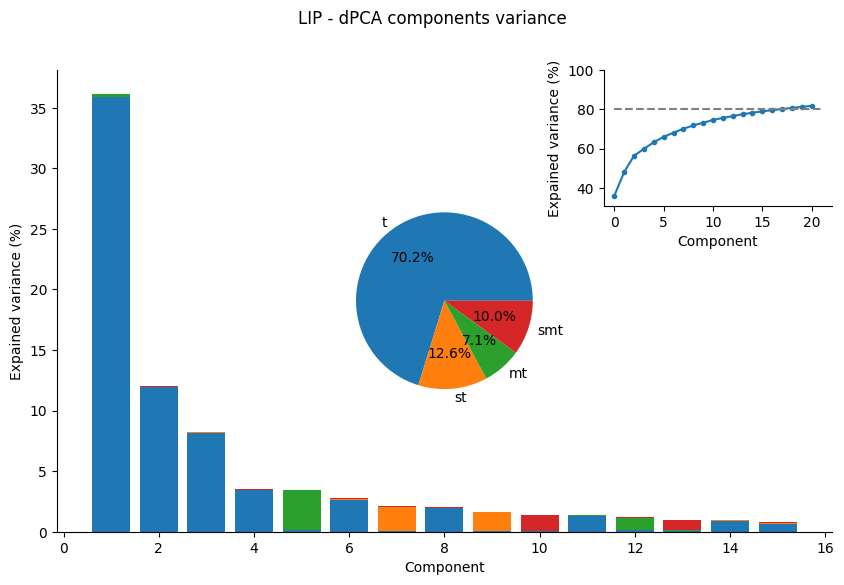

In [56]:
variances = dpca.get_variances(X)
n_comp=15
plot_variances(variances,n_comp,area,save_fig=False,basepath=None,n_trials=None)

In [18]:
comp_plot = 3

Z =   dpca.transform(X)#X_cen.T@dpca.D_sorted #
which_marg = variances['which_marg']
marg_labels=np.unique(which_marg)
components =np.concatenate([np.where(which_marg==i)[0][:comp_plot] for i in marg_labels])
comp_in_z = np.concatenate([[i]*comp_plot for i in marg_labels])

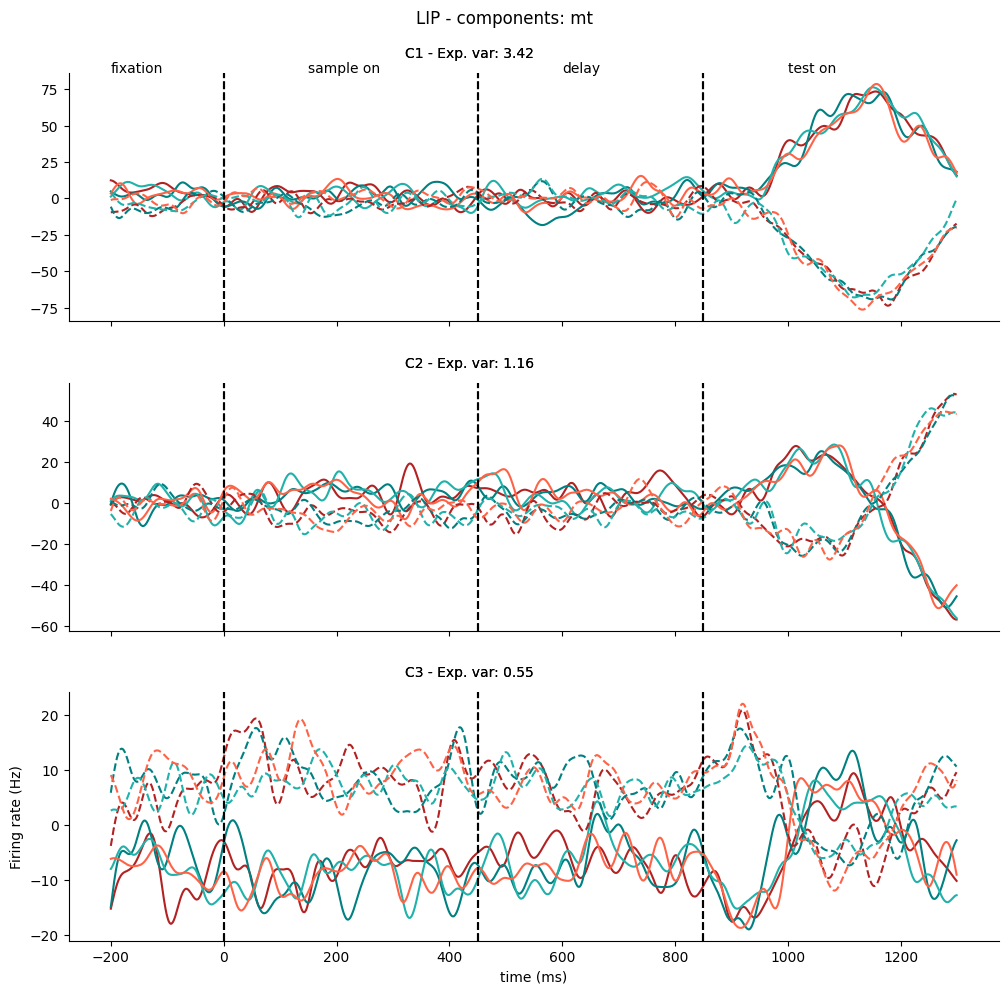

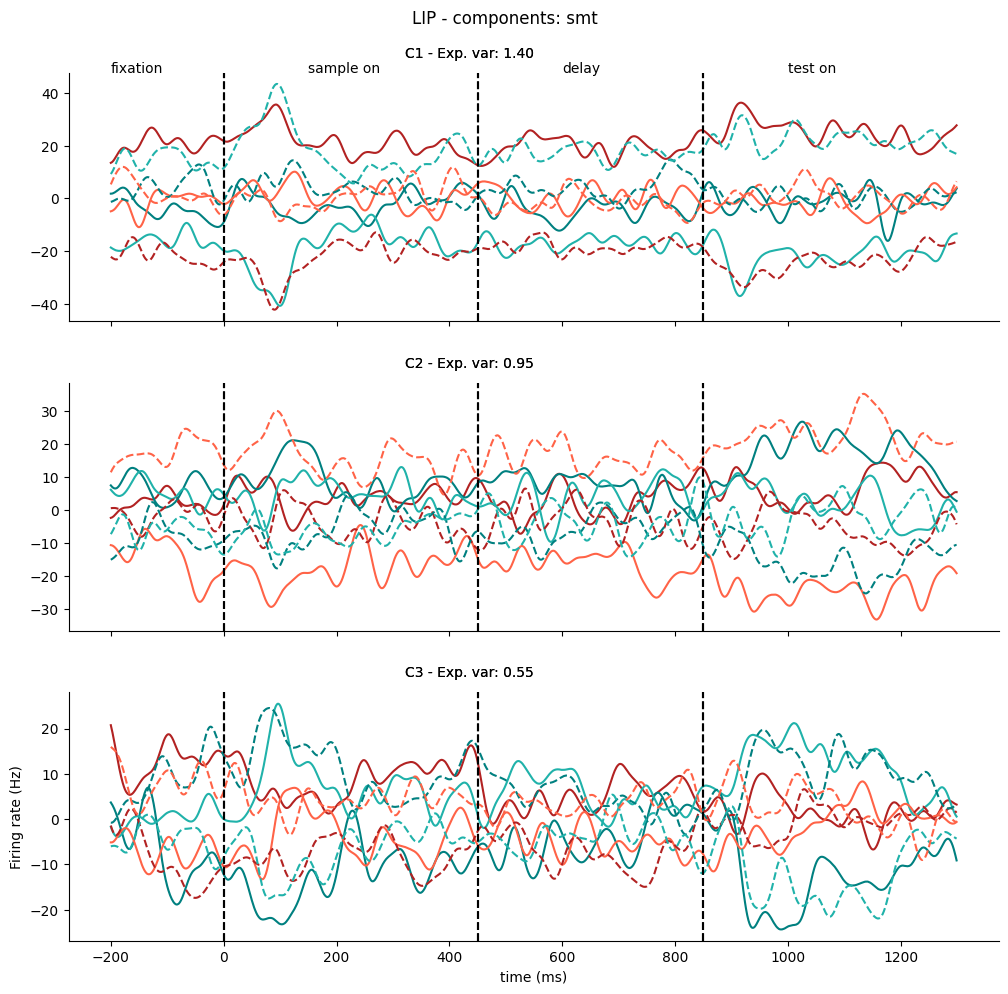

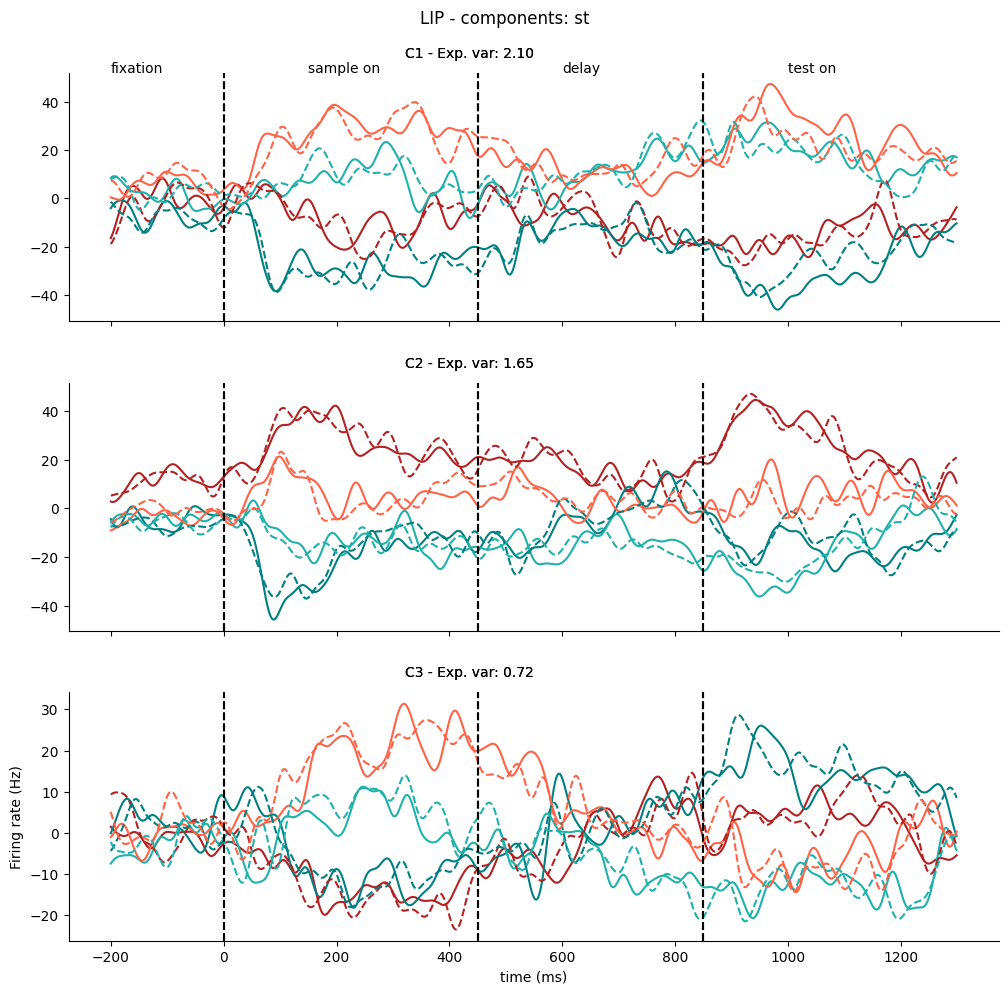

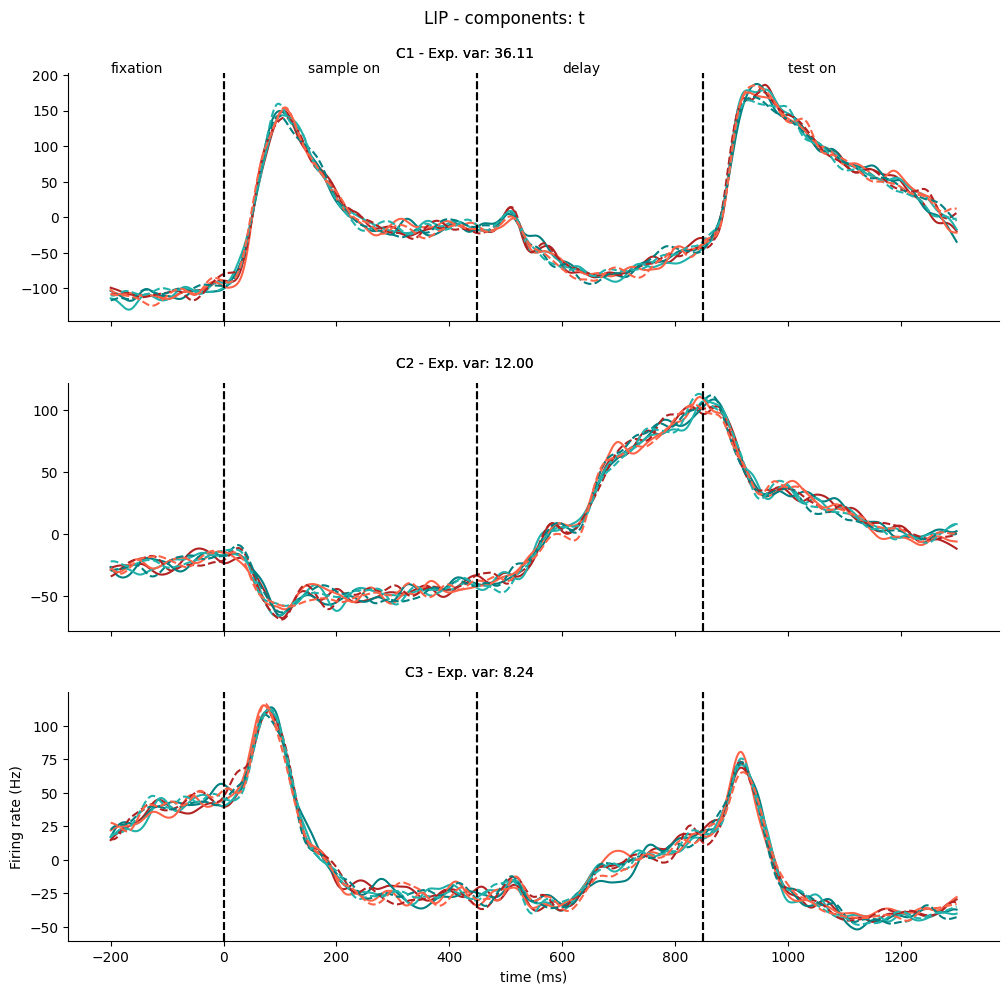

In [20]:
save_fig=False
time = np.arange(T-400)-200
plot_components(Z,comp_in_z,time,samples,variances,area,comp_plot=comp_plot,save_fig=False,basepath=None,n_trials=None)

In [21]:
def zero_mean( X):
    """Subtracts the mean from each observable"""
    return X - np.mean(X.reshape((X.shape[0], -1)), 1).reshape(
        (X.shape[0],) + (len(X.shape) - 1) * (1,)
    )

In [22]:
N = 45
lams = np.logspace(0, N, num=N, base=1.4, endpoint=False) * 1e-7

In [23]:
rng = np.random.default_rng(seed=seed)
tr = rng.integers(0,X_fr.shape[0],np.sum(X_fr.shape[2:-1]))


In [24]:
X_fr.shape

(10, 161, 4, 2, 1500)

In [25]:
X_fr[[tr[0],tr[1]],:,0,0].shape

(2, 161, 1500)

In [107]:
l_cv : Dict[str, list] = defaultdict(list)
# for each lamba:
# for it in range(10):
# select one fold and train
n_it=10
for reg in lams:
    # Define model
    dpca = dPCA.dPCA(labels='smt',join= {'st' : ['s','st'],'mt' : ['m','mt'],'smt': ['sm','smt']},regularizer=reg,n_components=40,n_iter=5)#X_fr.shape[1] ,'rt' : ['r','rt']
    dpca.protect = ['t']
    norm_error=[]
    for it in range(n_it):
        X_train , X_test = dpca.train_test_split( X, X_fr, N_samples=None, sample_ax=0)
        dpca.fit(X_test)
        Z_test = dpca.transform(X_test)
        squared_errors=[]
        X_marg_train=[]
        for i_m in marg_labels:
            X_pred = dpca.inverse_transform(Z_test[i_m],i_m)
            X_pred = X_pred.reshape(dpca.mXs[i_m].shape)
            X_orig = dpca.mXs[i_m]
            squared_errors.append(np.sum((X_orig- X_pred) ** 2, axis=1))
            X_marg_train.append(X_orig**2)
        norm_error.append(np.sum(squared_errors)/np.sum(X_marg_train)) #normalized reconstruction error
    l_cv['l_cv'] += [norm_error] 
    l_cv['reg'] += [[reg]*n_it]
    l_cv['it'] +=[list(range(n_it))]


In [97]:
np.argmin(np.mean(l_cv['l_cv'],axis=1))

2

Text(4.769999368104444e-08, 0.9353239489248276, '1.3999999999999998e-07')

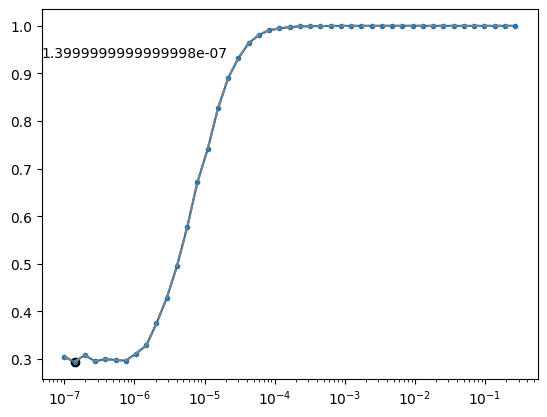

In [ ]:
np.array(l_cv['l_cv']).shape
f,ax=plt.subplots()
ax.plot(lams,np.mean(l_cv['l_cv'],axis=1),'.-')
ax.plot(lams,np.mean(l_cv['l_cv'],axis=1)-np.std(l_cv['l_cv'],axis=1),color='grey',linestyle='--')
ax.plot(lams,np.mean(l_cv['l_cv'],axis=1)+np.std(l_cv['l_cv'],axis=1),color='grey',linestyle='--')
ax.set_xscale('log')
ax.scatter(lams[np.argmin(np.mean(l_cv['l_cv'],axis=1))],np.min(np.mean(l_cv['l_cv'],axis=1)),color='k')
opt_reg = np.array(l_cv['reg'])[np.argmin(np.mean(l_cv['l_cv'],axis=1))][0]
ax.text(ax.get_xlim()[0], ax.get_ylim()[1]-0.1,str(opt_reg))

In [99]:
ax.get_xlim()[1]

0.5637872476894982

In [ ]:
dpca = dPCA.dPCA(labels='smt',join= {'st' : ['s','st'],'mt' : ['m','mt'],'smt': ['sm','smt']},regularizer=opt_reg,n_components=100,n_iter=5)#X_fr.shape[1] ,'rt' : ['r','rt']
dpca.protect = ['t']
#dpca.n_trials = 3
comp = dpca.fit(X)#_transform(X)

In [ ]:
variances = dpca.get_variances(X)

In [ ]:
comp_plot = 3

Z =   dpca.transform(X)#X_cen.T@dpca.D_sorted #
which_marg = variances['which_marg']
marg_labels=np.unique(which_marg)
components =np.concatenate([np.where(which_marg==i)[0][:comp_plot] for i in marg_labels])
comp_in_z = np.concatenate([[i]*comp_plot for i in marg_labels])

In [ ]:
mask,true_scores, scores = dpca.significance_analysis(X,X_fr,n_shuffles=10,n_splits=10,full=True)

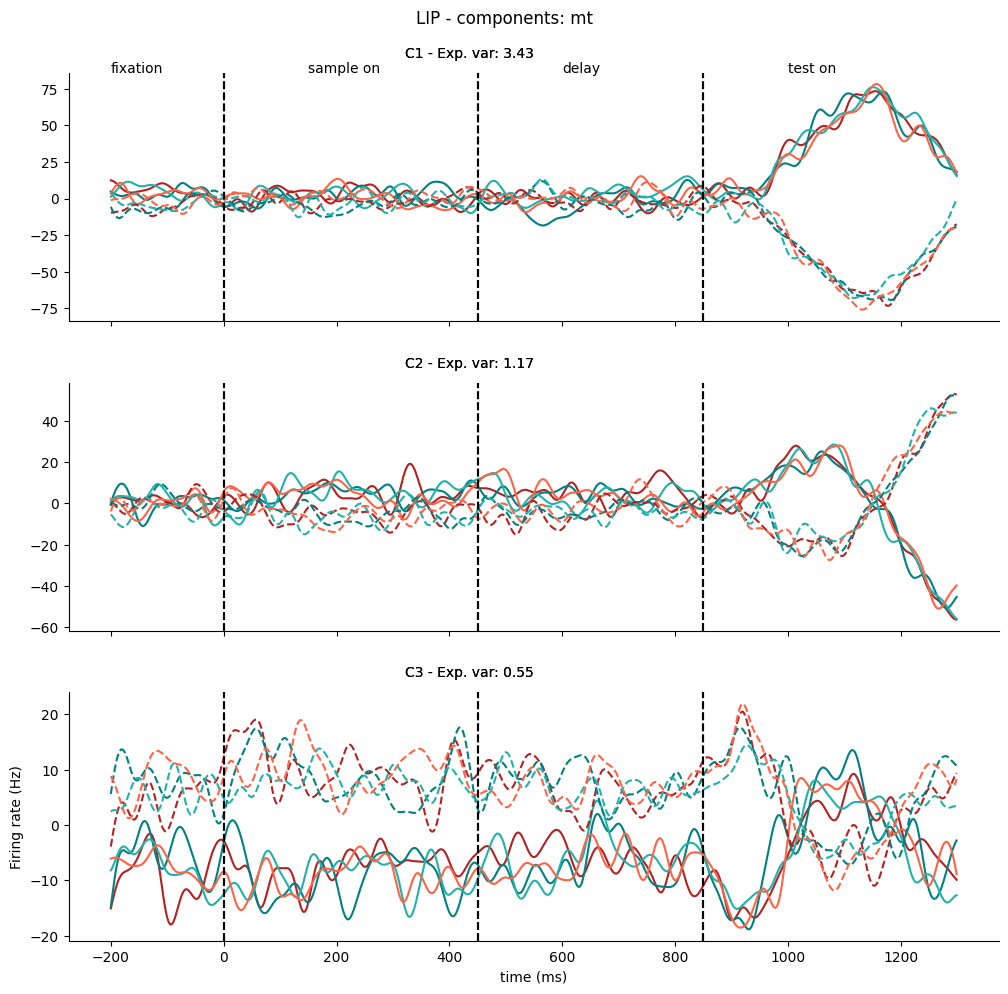

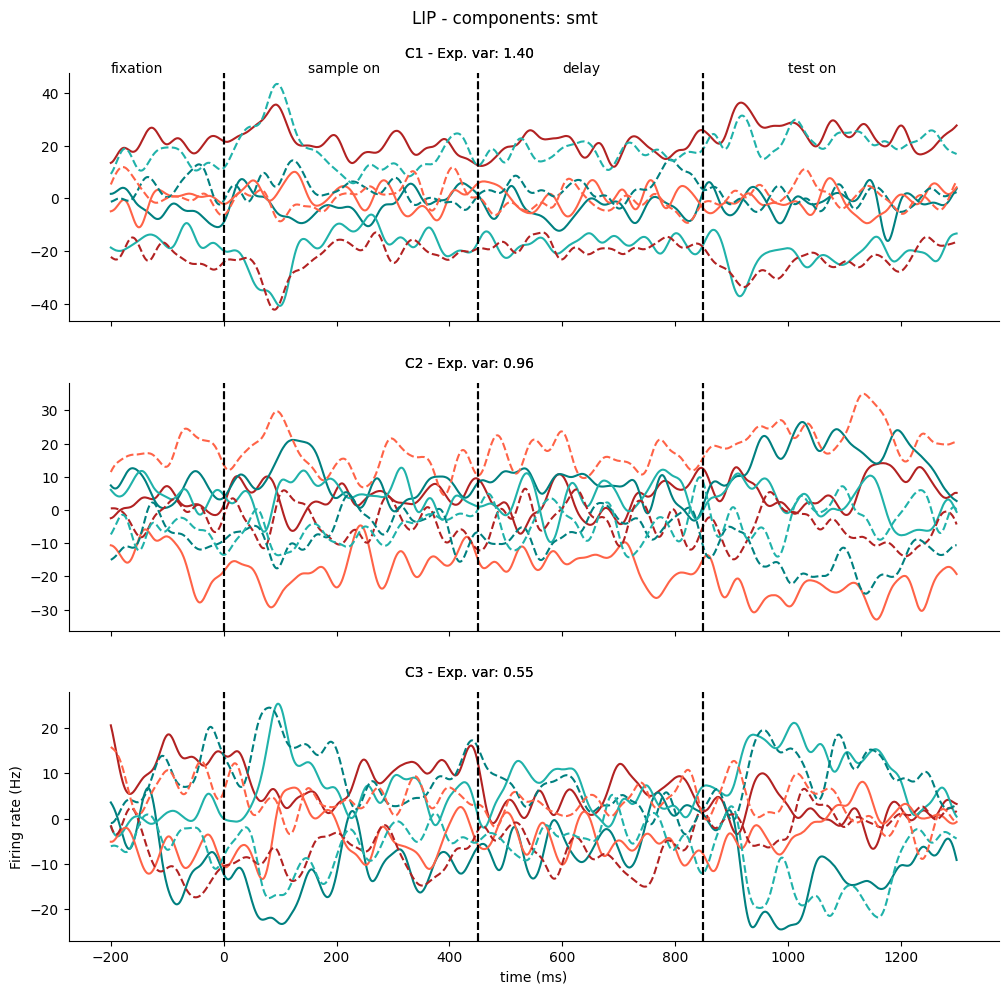

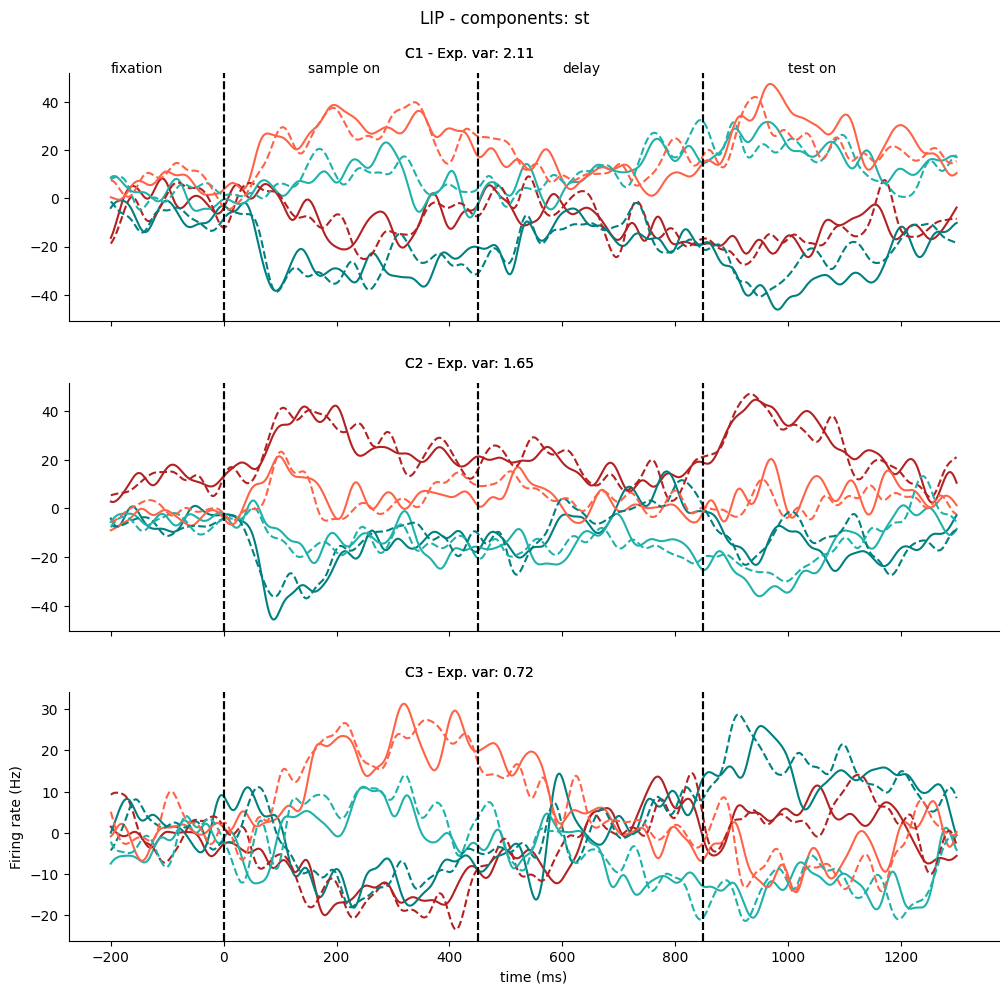

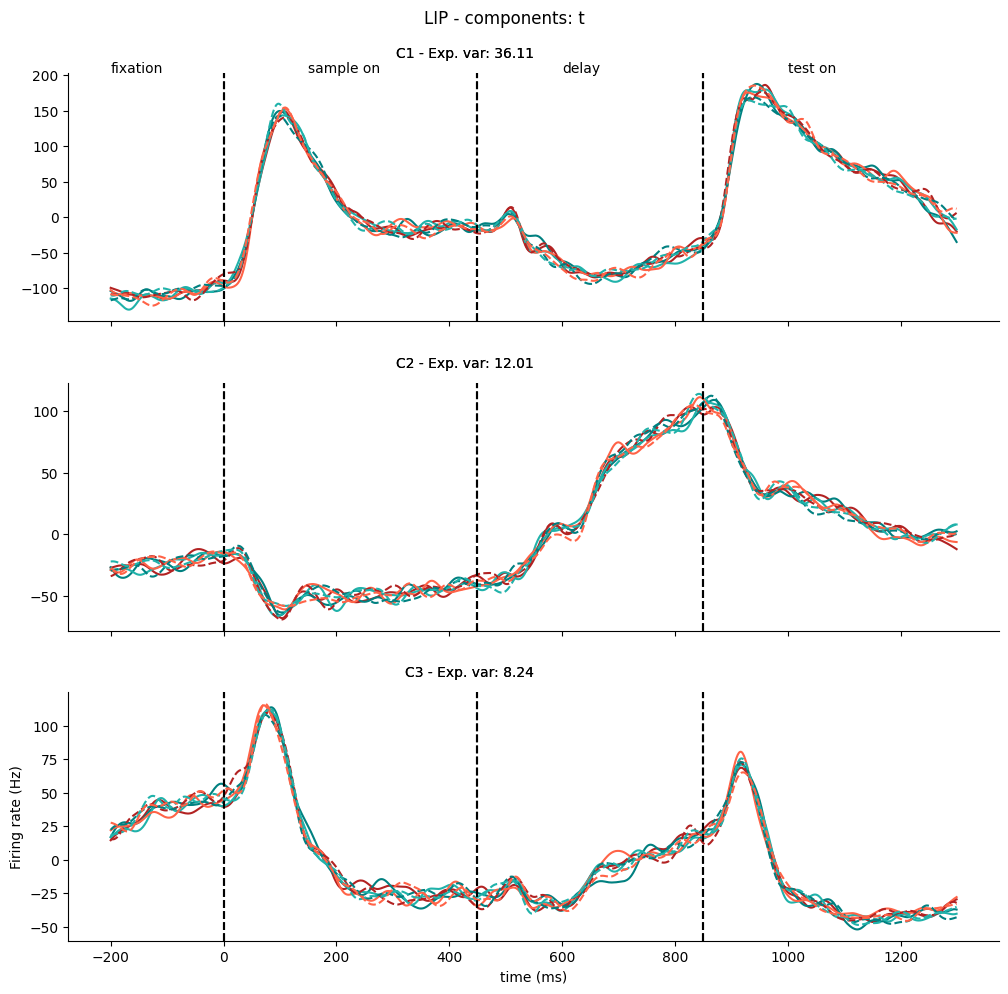

In [ ]:
save_fig=False
time = np.arange(T-400)-200
plot_components(Z,comp_in_z,time,samples,variances,area,comp_plot=comp_plot,save_fig=False,basepath=None,n_trials=None)